In [1]:
def MakePMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list):
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det
    nuzxhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det   
    
    J = np.ones((4,4), dtype = complex)
    
    P = np.zeros((4,4), dtype = complex)
    
    temp0 = np.array([[Uniform_zeta_list[which_layer][1][0], Uniform_zeta_list[which_layer][1][1], Uniform_mu_list[which_layer][1][0], Uniform_mu_list[which_layer][1][1]], [-Uniform_zeta_list[which_layer][0][0], -Uniform_zeta_list[which_layer][0][1], -Uniform_mu_list[which_layer][0][0], -Uniform_mu_list[which_layer][0][1]], [-Uniform_ep_list[which_layer][1][0], -Uniform_ep_list[which_layer][1][1], -Uniform_xi_list[which_layer][1][0], -Uniform_xi_list[which_layer][1][1]], [Uniform_ep_list[which_layer][0][0], Uniform_ep_list[which_layer][0][1], Uniform_xi_list[which_layer][0][0], Uniform_xi_list[which_layer][0][1]]])
    temp1 = np.diag((Uniform_zeta_list[which_layer][1][2]+kx0/omega, -Uniform_zeta_list[which_layer][0][2]+ky0/omega, -Uniform_ep_list[which_layer][1][2], Uniform_ep_list[which_layer][0][2]))
    temp2 = np.diag((nuzxee, nuzyee, nuzxeh, nuzyeh))
    
    temp3 = np.diag((Uniform_mu_list[which_layer][1][2], -Uniform_mu_list[which_layer][0][2], -Uniform_xi_list[which_layer][1][2]+kx0/omega, Uniform_xi_list[which_layer][0][2]+ky0/omega))
    temp4 = np.diag((nuzxhe, nuzyhe, nuzxhh, nuzyhh))
    
    P = omega*(temp0 + temp1 @ J @ temp2 + temp3 @ J @ temp4)
    
    return P


def Kmatrix(n, theta, phi):
    K   = np.array([[-np.sin(phi), -np.cos(phi)*np.cos(theta), -np.sin(phi), np.cos(phi)*np.cos(theta)], [np.cos(phi), -np.sin(phi)*np.cos(theta), np.cos(phi), np.sin(phi)*np.cos(theta)], [-n/eta0*np.cos(phi)*np.cos(theta), n/eta0*np.sin(phi), n/eta0*np.cos(phi)*np.cos(theta), n/eta0*np.sin(phi)], [-n/eta0*np.sin(phi)*np.cos(theta), -n1/eta0*np.cos(phi), n/eta0*np.sin(phi)*np.cos(theta), -n/eta0*np.cos(phi)]])
    
    return K
    
    
def MakeMMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    P = MakePMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list)
    
    w, v = np.linalg.eig(P)

    expG = np.zeros((4, 4), dtype = complex)
    
    for i in range(4):
        expG[i, i] = np.exp(1j*w[i]*thickness_list[which_layer])
    
    M  = v @ expG @ np.linalg.inv(v)
    
    return M

def BandStructure(M, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q1    = np.log(w)/(1j*np.sum(thickness_list))
    q     = np.zeros(q1.shape, dtype = float)
    
    for j in range(4):
        if np.abs(np.imag(q1[j])/np.abs(q1[j])) < 1e-5:
            q[j] = np.real(q1[j])*np.sum(thickness_list)
        else:
            q[j] = None
    
    sort = np.argsort(q)
    q    = np.sort(q)
    
    return q, sort

def Electric(M, omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q, sort = BandStructure(M, thickness_list[which_layer])
    
    vsort = np.zeros(v.shape, dtype = complex)
    for i in range(4):
        vsort[:,i] = v[:,sort[i]]
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det
    
    vex = np.zeros(4, dtype = complex)
    vey = np.zeros(4, dtype = complex)
    vez = np.zeros(4, dtype = complex)
    
    for i in range(4):
        vex[i] = vsort[0,i]
        vey[i] = vsort[1,i]
        vez[i] = nuzxee*vsort[0,i]+nuzyee*vsort[1,i]+nuzxeh*vsort[2,i]+nuzyeh*vsort[3,i]
    
    return np.array([vex, vey, vez])

def Magnetic(M, omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q, sort = BandStructure(M, thickness_list[which_layer])
    
    vsort = np.zeros(v.shape, dtype = complex)
    for i in range(4):
        vsort[:,i] = v[:,sort[i]]
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det   
    
    vhx = np.zeros(4, dtype = complex)
    vhy = np.zeros(4, dtype = complex)
    vhz = np.zeros(4, dtype = complex)
    
    for i in range(4):
        vhx[i] = vsort[2,i]
        vhy[i] = vsort[3,i]
        vhz[i] = nuzxhe*vsort[0,i]+nuzyhe*vsort[1,i]+nuzxhh*vsort[2,i]+nuzyhh*vsort[3,i]
    
    return np.array([vhx, vhy, vhz])

def Fields(ve, vh, M, incoming, z_offset, x_offset, y_offset, kx0, ky0, thickness):
    
    
    # Suppose we want to find the field in t-th layer,
    # M - Transfer Matrix of the t-th layer, ve, vh - electric and magnetic field eigenvectors in t-th layer, 
    # thickness - thickness of the t-th layer
    
    w, v = np.linalg.eig(M)
    q    = BandStructure(M, thickness)
    
    Coef = np.linalg.inv(v) @ incoming
    
    eh = []
    
    for j in range(len(z_offset)):
        ex = 0; ey = 0; ez = 0; hx = 0; hy = 0; hz = 0
        
        for i in range(4):
            ex += ve[0][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            ey += ve[1][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            ez += ve[2][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            
            hx += vh[0][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            hy += vh[1][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            hz += vh[2][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
        
        eh.append([[ex, ey, ez], [hx, hy, hz]])
    
    return eh


def RandT(M):
    r  = np.zeros((2,2), dtype = complex)
    t  = np.zeros((2,2), dtype = complex)
    
    det = (M[2,2]*M[3,3] - M[2,3]*M[3,2])
    
    r[0, 0] = (M[2, 3]*M[3,0]-M[2,0]*M[3,3])/det
    r[0, 1] = (M[2, 3]*M[3,1]-M[2,1]*M[3,3])/det
    r[1, 0] = (M[2, 0]*M[3,2]-M[3,0]*M[2,2])/det
    r[1, 1] = (M[2, 1]*M[3,2]-M[3,1]*M[2,2])/det
    
    t[0, 0] = ((M[0, 2]*M[2, 3]-M[0, 3]*M[2, 2])*M[3, 0]+(M[0, 3]*M[2,0]-M[0,0]*M[2, 3])*M[3,2]+(M[0,0]*M[2,2]-M[0, 2]*M[2,0])*M[3,3])/det
    t[0, 1] = M[0, 1] + ((M[0,2]*M[2,3]-M[0, 3]*M[2,2])*M[3,1]+(M[0, 3]*M[3, 2]-M[0, 2]*M[3,3])*M[2,1])/det
    t[1, 0] = ((M[1,2]*M[2,3]-M[1,3]*M[2,2])*M[3,0]+(M[1,3]*M[2,0]-M[1,0]*M[2,3])*M[3,2]+(M[1,0]*M[2,2]-M[1,2]*M[2,0])*M[3,3])/det
    t[1, 1] = M[1,1] + ((M[1,2]*M[2,3]-M[1,3]*M[2,2])*M[3,1]+(M[1,3]*M[3,2]-M[1,2]*M[3,3])*M[2,1])/det
    
    return r, t
    
def RefTrans(r, t, theta, n1, n2):
    Rss = np.abs(r[0,0])**2
    Rsp = np.abs(r[0,1])**2
    Rps = np.abs(r[1,0])**2
    Rpp = np.abs(r[1,1])**2
    
    thetar  = np.arcsin(n1*np.sin(theta)/n2)
    
    Tss = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[0,0])**2
    Tsp = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[0,1])**2
    Tps = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[1,0])**2
    Tpp = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[1,1])**2
    
    As = 1 - (Rss+Rps+Tss+Tps)
    Ap = 1 - (Rpp+Rsp+Tpp+Tsp)
    
    return Rss, Rsp, Rps, Rpp, Tss, Tsp, Tps, Tpp, As, Ap

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def EnDensity(weps, wmu, wgamma, elec1, elec2, mag1, mag2):
    
    coef1 = 1/2*(np.dot(np.conjugate(elec1), weps @ elec1)+np.dot(np.conjugate(mag1), wmu @ mag1)-2/c*np.imag(np.dot(np.conjugate(elec1), wgamma @ mag1)))
    
    coef2 = 1/2*(np.dot(np.conjugate(elec2), weps @ elec2)+np.dot(np.conjugate(mag2), wmu @ mag2)-2/c*np.imag(np.dot(np.conjugate(elec2), wgamma @ mag2)))
        
    elec1 = elec1/np.sqrt(coef1)
    mag1 = mag1/np.sqrt(coef1)
    elec2 = elec2/np.sqrt(coef2)
    mag2 = mag2/np.sqrt(coef2)
    
    
    res   = 1/2*(np.dot(np.conjugate(elec1), weps @ elec2)+np.dot(np.conjugate(mag1), wmu @ mag2)-2/c*np.imag(np.dot(np.conjugate(elec1), wgamma @ mag2)))
        
    return res

def EnDensity3(weps1, weps2, weps3, wmu1, wmu2, wmu3, elec11, elec12, elec13, elec21, elec22, elec23, mag11, mag12, mag13, mag21, mag22, mag23):
    
    coef11 = 1/2*(np.dot(np.conjugate(elec11), weps1 @ elec11)+np.dot(np.conjugate(mag11), wmu1 @ mag11))
    coef12 = 1/2*(np.dot(np.conjugate(elec12), weps2 @ elec12)+np.dot(np.conjugate(mag12), wmu2 @ mag12))
    coef13 = 1/2*(np.dot(np.conjugate(elec13), weps3 @ elec13)+np.dot(np.conjugate(mag13), wmu3 @ mag13))
    
    coef21 = 1/2*(np.dot(np.conjugate(elec21), weps1 @ elec21)+np.dot(np.conjugate(mag21), wmu1 @ mag21))
    coef22 = 1/2*(np.dot(np.conjugate(elec22), weps2 @ elec22)+np.dot(np.conjugate(mag22), wmu2 @ mag22))
    coef23 = 1/2*(np.dot(np.conjugate(elec23), weps3 @ elec23)+np.dot(np.conjugate(mag23), wmu3 @ mag23))
        
    elec11 = elec11/np.sqrt(coef11+coef12+coef13)
    elec12 = elec12/np.sqrt(coef11+coef12+coef13)
    elec13 = elec13/np.sqrt(coef11+coef12+coef13)
    mag11  = mag11/np.sqrt(coef11+coef12+coef13)
    mag12  = mag12/np.sqrt(coef11+coef12+coef13)
    mag13  = mag13/np.sqrt(coef11+coef12+coef13)
                  
    elec21 = elec21/np.sqrt(coef21+coef22+coef23)
    elec22 = elec22/np.sqrt(coef21+coef22+coef23)
    elec23 = elec23/np.sqrt(coef21+coef22+coef23)
    mag21  = mag21/np.sqrt(coef21+coef22+coef23)
    mag22  = mag22/np.sqrt(coef21+coef22+coef23)
    mag23  = mag23/np.sqrt(coef21+coef22+coef23)
    
    
    res1   = 1/2*(np.dot(np.conjugate(elec11), weps1 @ elec21)+np.dot(np.conjugate(mag11), wmu1 @ mag21))
    res2   = 1/2*(np.dot(np.conjugate(elec12), weps2 @ elec22)+np.dot(np.conjugate(mag12), wmu2 @ mag22))
    res3   = 1/2*(np.dot(np.conjugate(elec13), weps3 @ elec23)+np.dot(np.conjugate(mag13), wmu3 @ mag23))
                  
    return res1+res2+res3

In [69]:
import numpy as np
import scipy as sp
import scipy.constants as spcs


# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0, np.pi, 1000)
thetar  = np.arcsin(n1*np.sin(theta)/n2)
gammaz  = 0.8

dk      = 2221.44


e1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
h1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)

omega   = np.zeros(len(theta), dtype = float)

weps   = np.zeros((len(theta), 3, 3), dtype = float)

wxi    = (np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0))
wmu    = (mu0*np.eye(3))

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        omega[j] = omega_p+dk*c*np.cos(theta[j])
        
        weps[j] = (np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1+omega_p**2/omega[j]**2+gammaz**2]])*eps0)
        
        Uniform_ep_list = [np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega[j])**2+gammaz**2]])*eps0]
        Uniform_mu_list = [mu0*np.eye(3)]
        Uniform_xi_list = [np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
        Uniform_zeta_list = [-np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
        thickness_list  = [length]

        M1 = MakeMMatrix(omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
   
    
        q1[j, i], sort = BandStructure(M1, thickness_list)


        e1[j, i] = Electric(M1, omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        h1[j, i] = Magnetic(M1, omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        
for j in range(len(theta)):
    
    for i in range(len(phi)-1):
            
        inner = EnDensity(weps[j], wmu, wxi, e1[j, i, :, 3], e1[j, i+1, :, 3], h1[j, i, :, 3], h1[j, i+1, :, 3])
        
        berry1[j] = berry1[j] - np.imag(np.log(inner))
        
        inner = EnDensity(weps[j], wmu, wxi, e1[j, i, :, 1], e1[j, i+1, :, 1], h1[j, i, :, 1], h1[j, i+1, :, 1])
        berry2[j] = berry2[j] - np.imag(np.log(inner))
    
    berry1[j] = berry1[j] % (2*np.pi)
    berry2[j] = berry2[j] % (2*np.pi)
    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

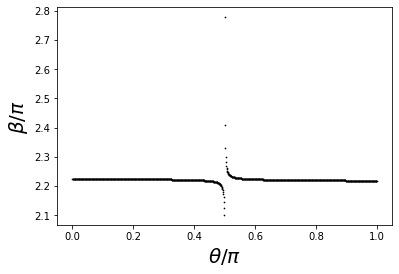

In [72]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, q1[:,0,3],s = 2, marker='.',  color = "black")

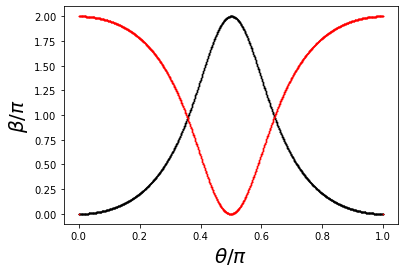

In [70]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 2, marker='.',  color = "black")
plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "red")

In [434]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0, np.pi, 1000)
phi1    = 2*np.pi/9
thetar  = np.arcsin(n1*np.sin(theta)/n2)
gammaz  = 0.8

dk      = 2221.44


ve1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)

omega   = np.zeros(len(theta), dtype = float)
weps1   = np.zeros((len(theta), 3, 3), dtype = float)
weps2   = np.zeros((len(theta), 3, 3), dtype = float)
weps3   = np.zeros((len(theta), 3, 3), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        omega[j] = omega_p+dk*c*np.cos(theta[j])
        
        epsA = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega[j])**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j]  = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1+omega_p**2/omega[j]**2]])*eps0
        weps2[j]  = rot @ weps1[j] @ np.linalg.inv(rot)
        weps3[j]  = matrix_power(rot, 2) @ weps1[j] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega[j], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega[j], 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega[j], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega[j], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega[j], 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega[j], 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)


    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)

wmu   = mu0*np.eye(3)
wxi   = np.zeros((3,3))*1j*np.sqrt(mu0*eps0)


for j in range(len(theta)):
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j], weps2[j], weps3[j], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i, :,3], vh2[j,i, :,3], vh3[j,i, :,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        berry1[j] = berry1[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j], weps2[j], weps3[j], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,2], ve2[j,i,:,2], ve3[j,i,:,2], ve1[j,i+1, :,2], ve2[j,i+1, :,2], ve3[j,i+1, :,2], vh1[j,i, :,2], vh2[j,i, :,2], vh3[j,i, :,2], vh1[j,i+1, :,2], vh2[j,i+1, :,2], vh3[j,i+1, :,2])
        berry2[j] = berry2[j] - np.imag(np.log(inner))
        
    berry1[j] = berry1[j] % (2*np.pi)
    berry2[j] = berry2[j] % (2*np.pi)

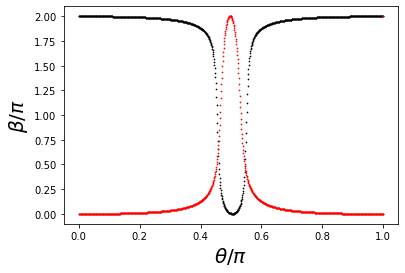

In [436]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 2, marker='.',  color = "black")
plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "red")

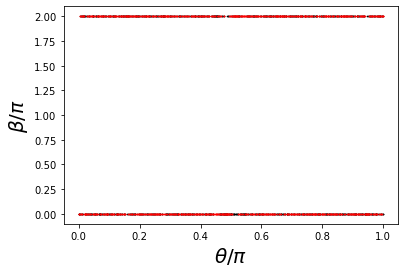

In [50]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 2, marker='.',  color = "black")
plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "red")

# Total dispersion $\omega$ ($k_x$, $k_y$)

In [572]:
import numpy as np
import scipy as sp
import scipy.constants as spcs


# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = 0
theta   = 0
thetar  = np.arcsin(n1*np.sin(theta)/n2)
gammaz  = 0.8

dk      = 2221.44

kx0     = np.linspace(-dk, dk, 1001)
ky0     = 0.


omega   = (1+0.7e-3)*omega_p

q1      = np.zeros((len(kx0), 4), dtype = float)

for j in range(len(kx0)):
        
    Uniform_ep_list = [np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega)**2+gammaz**2]])*eps0]
    Uniform_mu_list = [mu0*np.eye(3)]
    Uniform_xi_list = [np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
    Uniform_zeta_list = [-np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
    thickness_list  = [length]

    M1 = MakeMMatrix(omega, 0, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
   
    
    q1[j], sort = BandStructure(M1, thickness_list)


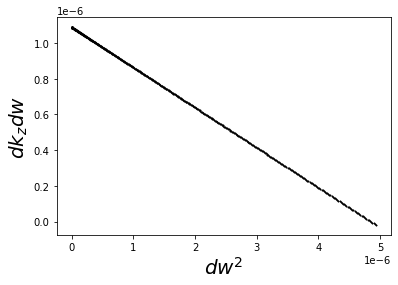

In [573]:
import matplotlib.pyplot as plt

plt.xlabel(r"$dw^2$", fontsize = 20)
plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.scatter((kx0*length)**2, (q1[:,3]-2.2214414690791835)*(omega/omega_p-1),s = 2, marker='.',  color = "black")
#plt.plot((kx0*length)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2)-np.sqrt(2)/(4*0.5*np.pi)*(kx0*length)**2)
#plt.scatter((omega/omega_p-1)**2, (q1[:,3]-2.2214414690791835)*(omega/omega_p-1),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1), (omega/omega_p-1)/c*length*omega_p*np.sqrt(2))

In [548]:
np.polyfit((kx0*length)**2, -(q1[:,3]-2.2214414690791835)*1e-3, 1)

array([-2.25328836e-01,  2.22162036e-06])

In [545]:
np.polyfit((ky0*length)**2, -(q1[:,3]-2.2214414690791835)*1e-3, 1)

array([-7.21105780e-02,  2.22161302e-06])

In [342]:
np.polyfit((omega/omega_p-1)**2, (q1[:,3]-2.2214414690791835)*(omega/omega_p-1), 1)

array([2.22144147e+00, 1.11768376e-17])

In [293]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

kx, ky = np.linspace(-100*dk*length, 100*dk*length, 101), np.linspace(-100*dk*length, 100*dk*length, 101)

w = np.zeros((len(kx), len(ky)), dtype = float)

for i in range(len(kx)):
    for j in range(len(ky)):
        w[i][j]  = -1.72981*10**(-9)*np.sqrt(3.3289*10**16*kx[i]**2 + 1.03344*10**16*ky[j]**2)
        
fig = go.Figure(data=[go.Surface(z=w, x=kx, y=ky), go.Surface(z=-w, x=kx, y=ky, showscale = False)])
fig.update_layout(title='w(kx, ky) dispersion', scene = dict(xaxis_title=r'$k_x$', yaxis_title= 'k_y', zaxis_title = ''), autosize=False,
                 width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                     zaxis = dict(nticks=4, range=[-0.045,0.045],),))
fig.update_scenes(aspectratio=dict(x = 1, y = 1, z = 2))
fig.show()

In [131]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
#phi     = np.linspace(0, 2*np.pi, 11)
#theta   = np.linspace(0, np.pi, 1001)
phi1    = 2*np.pi/9
thetar  = np.arcsin(n1*np.sin(theta)/n2)

dk      = 2221.44


kx0     = np.linspace(-dk, dk, 1001)
ky0     = 0.


omega   = (1-1e-3)*omega_p

q1      = np.zeros((len(kx0), 4), dtype = float)

for j in range(len(kx0)):
        
    epsA = np.array([[2.2, 0, 0], [0, 1.2, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
        
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
    Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
    Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
    thickness_list    = [dA/3, dA/3, dA/3]

    M1 = MakeMMatrix(omega, 0, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega, 1, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M3 = MakeMMatrix(omega, 2, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
    q1[j], sort = BandStructure(M3 @ M2 @ M1, thickness_list)

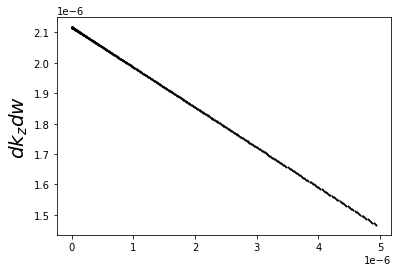

In [132]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.scatter((kx0*length)**2, (q1[:,3]-2.1882345816667197)*(omega/omega_p-1),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

In [118]:
np.polyfit((omega/omega_p-1)**2, (q1[:,3]-2.1882345816667197)*(omega/omega_p-1), 1)

array([2.23894006e+00, 1.36970918e-07])

In [122]:
np.polyfit((kx0*length)**2, (q1[:,3]-2.1882345816667197)*1e-3, 1)

array([-1.31782828e-01,  2.32581678e-06])

In [126]:
np.polyfit((ky0*length)**2, (q1[:,3]-2.1882345816667197)*1e-3, 1)

array([-9.33783601e-02,  2.32581288e-06])

In [130]:
np.polyfit((ky0*length)**2, -(q1[:,3]-2.1882345816667197)*1e-3, 1)

array([-9.32944721e-02,  2.11726285e-06])

In [133]:
np.polyfit((kx0*length)**2, -(q1[:,3]-2.1882345816667197)*1e-3, 1)

array([-1.31722618e-01,  2.11725871e-06])

In [125]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

kx, ky = np.linspace(-100*dk*length, 100*dk*length, 101), np.linspace(-100*dk*length, 100*dk*length, 101)

w1 = np.zeros((len(kx), len(ky)), dtype = float)
w2 = np.zeros((len(kx), len(ky)), dtype = float)

for i in range(len(kx)):
    for j in range(len(ky)):
        #w[i][j]  = -9.7227*10**(-9)*np.sqrt(6.56548*10**14*kx[i]**2 + 4.53924*10**14*ky[j]**2)
        w1[j][i]  = np.sqrt(0.438307*(0.129099*kx[i]**2 + 0.0908401*ky[j]**2))+1
        w2[j][i]  = -np.sqrt(0.438307*(0.129963*kx[i]**2 + 0.0916792*ky[j]**2))+1
        
fig = go.Figure(data=[go.Surface(z=w1, x=kx, y=ky), go.Surface(z=w2, x=kx, y=ky, showscale = False)])
fig.update_layout(title=r'$\omega(k_x, k_y)\ \text{dispersion}$', autosize=False,
                 width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                     zaxis = dict(nticks=4, range=[0.95,1.05],),))
fig.update_scenes(aspectratio=dict(x = 1, y = 1, z = 2))
fig.update_traces(showscale=False)
fig.show()

In [102]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

ky, kz = np.linspace(-100*dk*length, 100*dk*length, 101), np.linspace(-50*dk*length, 50*dk*length, 101)

w1 = np.zeros((len(ky), len(kz)), dtype = float)
w2 = np.zeros((len(ky), len(kz)), dtype = float)

beta    = 2.28150685e+00
alpha1  = 1.29099061e-01
alpha2  = 9.08400690e-02
a1      = 1.29963239e-01
a2      = 9.16792119e-02

kx      = 0

for i in range(len(ky)):
    for j in range(len(kz)):
        #w[i][j]  = -9.7227*10**(-9)*np.sqrt(6.56548*10**14*kx[i]**2 + 4.53924*10**14*ky[j]**2)
        if kz[j] >= 0:
            w1[j][i]  = (kz[j]+np.sqrt(kz[j]**2+4*alpha1*beta*kx**2+4*alpha2*beta*ky[i]**2))/(2*beta)
            w2[j][i]  = (kz[j]-np.sqrt(kz[j]**2+4*alpha1*beta*kx**2+4*alpha2*beta*ky[i]**2))/(2*beta)
        else:
            w1[j][i]  = (kz[j]+np.sqrt(kz[j]**2+4*a1*beta*kx**2+4*a2*beta*ky[i]**2))/(2*beta)
            w2[j][i]  = (kz[j]-np.sqrt(kz[j]**2+4*a1*beta*kx**2+4*a2*beta*ky[i]**2))/(2*beta)
        
fig = go.Figure(data=[go.Surface(z=w1, x=ky, y=kz), go.Surface(z=w2, x=ky, y=kz, showscale = False)])
fig.update_layout(title='w(ky, kz) dispersion', scene = dict(xaxis_title=r'$k_y$', yaxis_title= 'k_z', zaxis_title = ''), autosize=False,
                 width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                     zaxis = dict(nticks=4, range=[-0.05,0.05],),))
fig.update_scenes(aspectratio=dict(x = 1, y = 1, z = 2))
fig.show()

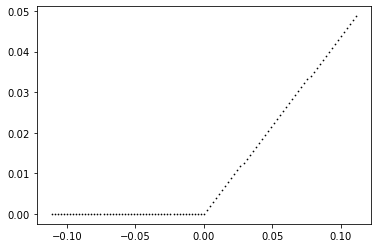

In [51]:
import matplotlib.pyplot as plt

plt.scatter(kz, w1[:,50],s = 2, marker='.',  color = "black")
#plt.scatter(ky, w2[50][:],s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

# $k_x, k_y, k_z$ parametric space

In [145]:
import numpy as np
import scipy as sp
import scipy.constants as spcs


# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.01*np.pi, 0.99*np.pi, 1001)
thetar  = np.arcsin(n1*np.sin(theta)/n2)
gammaz  = 0.8

dk      = 2221.44

beta    = 2.22144147e+00
alpha1  = 2.24825783e-01
alpha2  = 7.19415843e-02
a1      = 2.25328836e-01
a2      = 7.21105780e-02

e1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
h1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)
dw     = np.zeros((len(theta), len(phi)), dtype = float)

weps   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

wxi    = (np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0))
wmu    = (mu0*np.eye(3))

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)
berry3 = np.zeros(len(theta), dtype = float)
berry4 = np.zeros(len(theta), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i]  = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i]  = -(-dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        weps[j][i] = (np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1+omega_p**2/omega**2+gammaz**2]])*eps0)
        
        Uniform_ep_list = [np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega)**2+gammaz**2]])*eps0]
        Uniform_mu_list = [mu0*np.eye(3)]
        Uniform_xi_list = [np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
        Uniform_zeta_list = [-np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
        thickness_list  = [length]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
   
    
        q1[j, i], sort = BandStructure(M1, thickness_list)


        e1[j, i] = Electric(M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        h1[j, i] = Magnetic(M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)

inner1 = 0.+1j*0.

for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 3]
    ma1 = h1[j, 0, :, 3]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry1[j] = berry1[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry1[j] = berry1[j] % (2*np.pi)
    
for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 2]
    ma1 = h1[j, 0, :, 2]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry2[j] = berry2[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry2[j] = berry2[j] % (2*np.pi)
    
for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 1]
    ma1 = h1[j, 0, :, 1]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry3[j] = berry3[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry3[j] = berry3[j] % (2*np.pi)
    
for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 0]
    ma1 = h1[j, 0, :, 0]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry4[j] = berry4[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry4[j] = berry4[j] % (2*np.pi)
    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

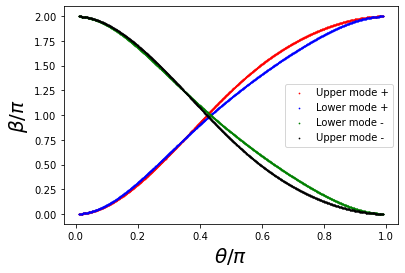

In [146]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 2, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "blue")
plt.scatter(theta/np.pi, berry3/np.pi,s = 2, marker='.',  color = "green")
plt.scatter(theta/np.pi, berry4/np.pi,s = 2, marker='.',  color = "black")
plt.legend(['Upper mode +', 'Lower mode +', 'Lower mode -', 'Upper mode -'])

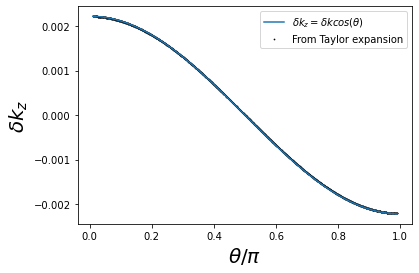

In [147]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\delta k_z$", fontsize = 20)
plt.scatter(theta/np.pi, (q1[:,0,3]-2.2214414690791835),s = 2, marker='.',  color = "black")
#plt.scatter(theta/np.pi, q1[:,0,3]-2.2214414690791835,s = 2, marker='.',  color = "black")
#plt.xlim([0.45, 0.55])
#plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "red")
plt.plot(theta/np.pi, dk*length*np.cos(theta))
plt.legend([r'$\delta k_z = \delta k cos(\theta)$', 'From Taylor expansion'])

In [3]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.001*np.pi, 0.999*np.pi, 1001)
phi1    = 2*np.pi/9
thetar  = np.arcsin(n1*np.sin(theta)/n2)

dk      = 2221.44

beta    = 2.28150685e+00
alpha1  = 1.29099061e-01
alpha2  = 9.08400690e-02
a1      = 1.29963239e-01
a2      = 9.16792119e-02

ve1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)


weps1   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps2   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps3   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw = -(-dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw)*omega_p
        
        epsA = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)


    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)
berry3 = np.zeros(len(theta), dtype = float)
berry4 = np.zeros(len(theta), dtype = float)

wmu   = mu0*np.eye(3)
wxi   = np.zeros((3,3))*1j*np.sqrt(mu0*eps0)

for j in range(len(theta)):
    
    
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry1[j] = berry1[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,2], ve2[j,i,:,2], ve3[j,i,:,2], ve1[j,i+1, :,2], ve2[j,i+1, :,2], ve3[j,i+1, :,2], vh1[j,i,:,2], vh2[j,i,:,2], vh3[j,i,:,2], vh1[j,i+1, :,2], vh2[j,i+1, :,2], vh3[j,i+1, :,2])
        
        berry2[j] = berry2[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,1], ve2[j,i,:,1], ve3[j,i,:,1], ve1[j,i+1, :,1], ve2[j,i+1, :,1], ve3[j,i+1, :,1], vh1[j,i,:,1], vh2[j,i,:,1], vh3[j,i,:,1], vh1[j,i+1, :,1], vh2[j,i+1, :,1], vh3[j,i+1, :,1])
        
        berry3[j] = berry3[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,0], ve2[j,i,:,0], ve3[j,i,:,0], ve1[j,i+1, :,0], ve2[j,i+1, :,0], ve3[j,i+1, :,0], vh1[j,i,:,0], vh2[j,i,:,0], vh3[j,i,:,0], vh1[j,i+1, :,0], vh2[j,i+1, :,0], vh3[j,i+1, :,0])
        
        berry4[j] = berry4[j] - np.imag(np.log(inner))
        
    berry1[j] = berry1[j] % (2*np.pi)
    berry2[j] = berry2[j] % (2*np.pi)
    berry3[j] = berry3[j] % (2*np.pi)
    berry4[j] = berry4[j] % (2*np.pi)

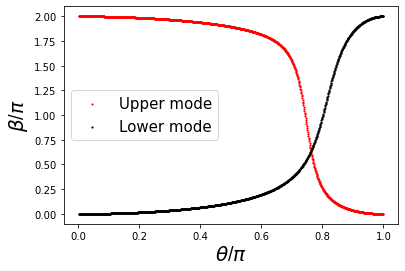

In [88]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 5, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 5, marker='.',  color = "black")
#plt.scatter(theta/np.pi, berry3/np.pi,s = 2, marker='.',  color = "green")
#plt.scatter(theta/np.pi, berry4/np.pi,s = 2, marker='.',  color = "black")
plt.legend(['Upper mode', 'Lower mode'], fontsize=15)

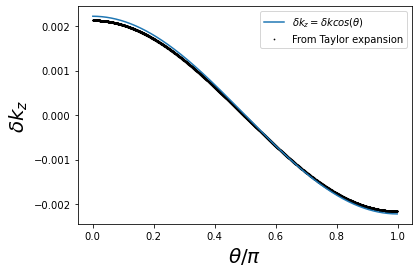

In [175]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\delta k_z$", fontsize = 20)
plt.scatter(theta/np.pi, q1[:,0,3]-2.1758189736985685-9.228285823604615e-05,s = 2, marker='.',  color = "black")
#plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "red")
plt.plot(theta/np.pi, dk*length*np.cos(theta))
plt.legend([r'$\delta k_z = \delta k cos(\theta)$', 'From Taylor expansion'])

In [26]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.001*np.pi, 0.999*np.pi, 1001)
phi1    = 2*np.pi/9
thetar  = np.arcsin(n1*np.sin(theta)/n2)

dk      = 2221.44

beta    = 2.11724888e+00
alpha1  = 8.88228437e-02
alpha2  = 1.25708406e-01
a1      = 8.71745340e-02
a2      = 1.24090076e-01

ve1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)


weps1   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps2   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps3   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw = -(-dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw)*omega_p
        
        epsA = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)


    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)
berry3 = np.zeros(len(theta), dtype = float)
berry4 = np.zeros(len(theta), dtype = float)

wmu   = mu0*np.eye(3)
wxi   = np.zeros((3,3))*1j*np.sqrt(mu0*eps0)

for j in range(len(theta)):
    
    
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry1[j] = berry1[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,2], ve2[j,i,:,2], ve3[j,i,:,2], ve1[j,i+1, :,2], ve2[j,i+1, :,2], ve3[j,i+1, :,2], vh1[j,i,:,2], vh2[j,i,:,2], vh3[j,i,:,2], vh1[j,i+1, :,2], vh2[j,i+1, :,2], vh3[j,i+1, :,2])
        
        berry2[j] = berry2[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,1], ve2[j,i,:,1], ve3[j,i,:,1], ve1[j,i+1, :,1], ve2[j,i+1, :,1], ve3[j,i+1, :,1], vh1[j,i,:,1], vh2[j,i,:,1], vh3[j,i,:,1], vh1[j,i+1, :,1], vh2[j,i+1, :,1], vh3[j,i+1, :,1])
        
        berry3[j] = berry3[j] - np.imag(np.log(inner))
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,0], ve2[j,i,:,0], ve3[j,i,:,0], ve1[j,i+1, :,0], ve2[j,i+1, :,0], ve3[j,i+1, :,0], vh1[j,i,:,0], vh2[j,i,:,0], vh3[j,i,:,0], vh1[j,i+1, :,0], vh2[j,i+1, :,0], vh3[j,i+1, :,0])
        
        berry4[j] = berry4[j] - np.imag(np.log(inner))
        
    berry1[j] = berry1[j] % (2*np.pi)
    berry2[j] = berry2[j] % (2*np.pi)
    berry3[j] = berry3[j] % (2*np.pi)
    berry4[j] = berry4[j] % (2*np.pi)

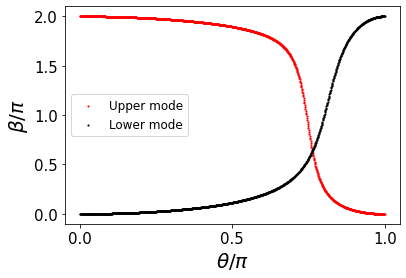

In [29]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontname = "Arial", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 5, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 5, marker='.',  color = "black")
plt.xticks(np.arange(0, 1.1, step=0.5), fontsize = 15)
plt.yticks(np.arange(0, 2.1, step=0.5), fontsize = 15)
#plt.scatter(theta/np.pi, berry3/np.pi,s = 2, marker='.',  color = "green")
#plt.scatter(theta/np.pi, berry4/np.pi,s = 2, marker='.',  color = "black")
plt.legend(['Upper mode', 'Lower mode'], fontsize='large')

In [28]:
import scipy.io

scipy.io.savemat('test1.mat', dict(x=theta/np.pi, y=berry1/np.pi, z=berry2/np.pi))

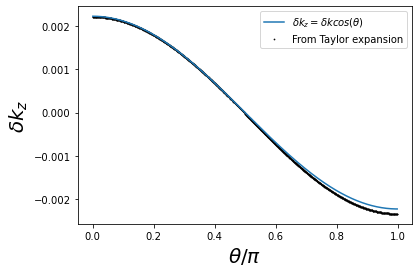

In [65]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\delta k_z$", fontsize = 20)
plt.scatter(theta/np.pi, q1[:,0,2]-2.098019050333991-9.228285823604615e-05,s = 2, marker='.',  color = "black")
#plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "red")
plt.plot(theta/np.pi, dk*length*np.cos(theta))
plt.legend([r'$\delta k_z = \delta k cos(\theta)$', 'From Taylor expansion'])

In [43]:
dw

-0.0010492073488750646

# Some band structure

In [1]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
m       = 1000
length  = 1e-6
omega   = np.linspace(0.5e-4*np.pi*c/length, 0.65*np.pi*c/length, m)
n1      = 1
n2      = 1
theta   = 0
phi     = 0
phi1    = 2*np.pi/9



omega_p = 0.5*np.pi*c/length

kx0     = 0.05/length
ky0     = 0.

    
# material parameters


q1    = np.zeros((m, 4), dtype = float)

for i in range(m):
    epsA = np.array([[2.2, 0, 0], [0, 1.2, 0], [0, 0, 1 - (omega_p/omega[i])**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
    
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
    Uniform_mu_list = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
    Uniform_xi_list = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
    thickness_list  = [dA/3, dA/3, dA/3]
    
    M1 = MakeMMatrix(omega[i], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega[i], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M3 = MakeMMatrix(omega[i], 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
        
    q1[i], sort  = BandStructure(M3 @ M2 @ M1, thickness_list)
    
    
    Uniform_ep_list = []
    Uniform_mu_list = []
    Uniform_xi_list = []
    Uniform_zeta_list = []
    thickness_list  = []

NameError: name 'MakeMMatrix' is not defined

In [3]:
import scipy.constants as spcs
import numpy as np

spcs.c*0.5*np.pi/1e-6

470912891827213.3

([], [])

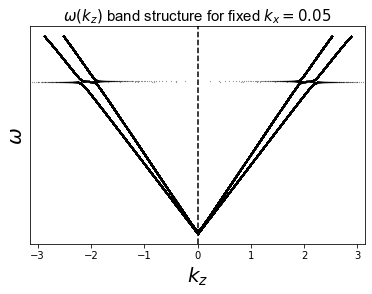

In [17]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(6,4))

plt.title(r'$\omega(k_z)$ band structure for fixed $k_x = 0.05$', fontname = "Arial", fontsize = 15)
plt.xlabel(r"$k_z$", fontname = "Arial", fontsize = 20)
plt.ylabel(r"$\omega$", fontsize = 20)
plt.scatter(q1[:, 0], omega,s = 0.1, marker='.',  color = "black")
plt.scatter(q1[:, 1], omega,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 2], omega,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 3], omega,s = 0.1, marker='.', color = "black")
plt.axvline(0, linestyle='--', color='k')
plt.xlim([-np.pi, np.pi])
plt.yticks([])

In [15]:
omega[m-1]/omega_p

1.3

In [25]:
import scipy.io

scipy.io.savemat('test.mat', dict(x=q1, y=omega/omega_p))

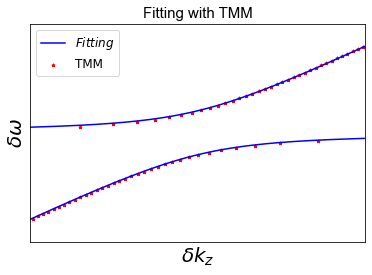

In [24]:
from matplotlib import pyplot as plt 

beta = 2.23894006e+00
ax   = 1.31782828e-01

dkz  = np.linspace(-0.1, 0.1, 1001)

plt.figure(figsize=(6,4))

plt.title(r'Fitting with TMM', fontname = "Arial", fontsize = 15)
plt.xlabel(r"$\delta k_z$", fontsize = 20)
plt.ylabel(r"$\delta\omega$", fontsize = 20)
plt.scatter(q1[:, 3], omega,s = 10, marker='*', color = "red")
plt.plot(dkz+2.1882345816667197, ((dkz + np.sqrt(dkz**2 + 4*ax*beta*0.05**2))/(2*beta)+1)*omega_p, color = "blue")
plt.plot(dkz+2.1882345816667197, ((dkz - np.sqrt(dkz**2 + 4*ax*beta*0.05**2))/(2*beta)+1)*omega_p, color = "blue", label='_nolegend_')
plt.xlim([2.1882345816667197-0.1, 2.1882345816667197+0.1])
plt.ylim([0.94*omega_p, 1.06*omega_p])
plt.yticks([])
plt.xticks([])
plt.legend([r'$Fitting$' , 'TMM'], fontsize = 'large')

# Nonlocal Metasurface

In [181]:
import numpy as np
import scipy as sp
import scipy.constants as spcs


# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
m       = 100000
length  = 1e-6
omega   = np.linspace(0.5e-4*np.pi*c/length, 0.65*np.pi*c/length, m)
n1      = 1
n2      = 1
theta   = 0
phi     = 0
phi1    = 2*np.pi/9

gammaz  = 0.8

omega_p = 0.5*np.pi*c/length

kx0     = omega/c*np.sin(theta)*np.cos(phi)
ky0     = omega/c*np.sin(theta)*np.sin(phi)

    
# material parameters


q1    = np.zeros((m, 4), dtype = float)

for i in range(m):
    epsA = np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega[i])**2+gammaz**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA = np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)
    zetA = -np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)
    dA   = length
    
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA]
    Uniform_mu_list = [muA]
    Uniform_xi_list = [xiA]
    Uniform_zeta_list = [zetA]
    thickness_list  = [dA]
    
    M1 = MakeMMatrix(omega[i], 0, kx0[i], ky0[i], Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        
    q1[i], sort  = BandStructure(M1, thickness_list)
    
    
    Uniform_ep_list = []
    Uniform_mu_list = []
    Uniform_xi_list = []
    Uniform_zeta_list = []
    thickness_list  = []

([], [])

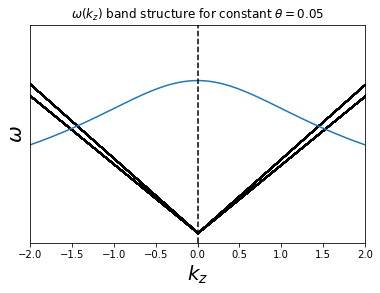

In [191]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(6,4))

kz   = np.linspace(-np.pi, np.pi, m)

plt.title(r'$\omega(k_z)$ band structure for constant $\theta = 0.05$')
plt.xlabel(r"$k_z$", fontsize = 20)
plt.ylabel(r"$\omega$", fontsize = 20)
plt.scatter(q1[:, 0], omega,s = 0.1, marker='.',  color = "black")
plt.scatter(q1[:, 1], omega,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 2], omega,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 3], omega,s = 0.1, marker='.', color = "black")
plt.plot(kz, omega_p/np.sqrt(1+0.5*kz**2))
plt.axvline(0, linestyle='--', color='k')
plt.xlim([-2, 2])
plt.yticks([])

The cross points are ($k_z$, $\omega/\omega_p$) = (1.51555, 0.682241) and ($k_z$, $\omega/\omega_p$) = (1.43666, 0.701519).

In [319]:
import numpy as np
import scipy as sp
import scipy.constants as spcs


# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = 0
theta   = 0
thetar  = np.arcsin(n1*np.sin(theta)/n2)
gammaz  = 0.8
alpha   = 0.5

dk      = 2221.44

kx0     = 0.
ky0     = 0.


omega   = np.linspace((1+1e-3)*0.682241*omega_p, (1+5e-3)*0.682241*omega_p, 1001)

q1      = np.zeros((len(omega), 4), dtype = float)
q1[0,3] = 1.51555
q1[0,2] = 1.51555
q1[0,1] = -1.51555
q1[0,0] = -1.51555

for j in range(len(omega)-1):
    
        
    Uniform_ep_list = [np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega[j])**2+gammaz**2+alpha*q1[j,3]**2]])*eps0]
    Uniform_mu_list = [mu0*np.eye(3)]
    Uniform_xi_list = [np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
    Uniform_zeta_list = [-np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
    thickness_list  = [length]

    M1 = MakeMMatrix(omega[j+1], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
   
    
    q1[j+1], sort = BandStructure(M1, thickness_list)


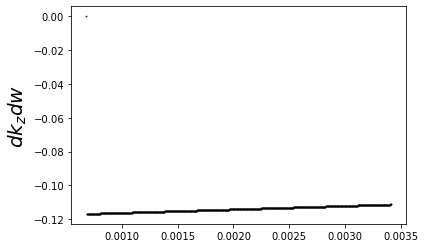

In [349]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.scatter((omega/omega_p-0.682241), (q1[:,2]-1.51555),s = 2, marker='.',  color = "black")
#plt.plot((ky0*length),2.24668780e+09*(ky0*length)**3+-8.63385206e+05*(ky0*length)**2+-3.83410366e+00*(ky0*length)+9.34821122e-05)
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))
#plt.ylim([-0.12, -0.1])

In [342]:
q1[1,2]-1.51555

-0.116871284946229

In [292]:
np.polyfit((ky0*length)**2, -(q1[:,3]-1.51555)*1e-3, 1)

array([-4.90230264e-02,  1.50722584e-06])

In [289]:
np.polyfit((kx0*length)**2, -(q1[:,3]-1.51555)*1e-3, 1)

array([-1.53737648e-01,  1.50723082e-06])

In [284]:
np.polyfit((omega/omega_p-0.682241)**2, (q1[:,3]-1.51555)*(omega/omega_p-0.682241), 1)

array([2.22553927e+00, 4.19593718e-09])

In [ ]:
import numpy as np
import scipy as sp
import scipy.constants as spcs


# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.01*np.pi, 0.99*np.pi, 1001)
thetar  = np.arcsin(n1*np.sin(theta)/n2)
gammaz  = 0.8
alpha   = 0.5

dk      = 2221.44

beta    = 2.22553927e+00
alpha1  = 1.53376319e-01
alpha2  = 4.92550033e-02
a1      = 1.53737648e-01
a2      = 4.90230264e-02

e1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
h1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)
dw     = np.zeros((len(theta), len(phi)), dtype = float)

weps   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

wxi    = (np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0))
wmu    = (mu0*np.eye(3))

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)
berry3 = np.zeros(len(theta), dtype = float)
berry4 = np.zeros(len(theta), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i]  = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i]  = -(-dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*0.682241*omega_p
        
        weps[j][i] = (np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1+omega_p**2/omega**2+gammaz**2+alpha*(1.51555+dkz*length)**2]])*eps0)
        
        Uniform_ep_list = [np.array([[2., 0, 0], [0, 1.7, 0], [0, 0, 1 - (omega_p/omega)**2+gammaz**2+alpha*1.51555**2]])*eps0]
        Uniform_mu_list = [mu0*np.eye(3)]
        Uniform_xi_list = [np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
        Uniform_zeta_list = [-np.array([[0, 0, 0], [0, 0, 0], [0, 0, gammaz]])*1j*np.sqrt(mu0*eps0)]
        thickness_list  = [length]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
   
    
        q1[j, i], sort = BandStructure(M1, thickness_list)


        e1[j, i] = Electric(M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        h1[j, i] = Magnetic(M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)

inner1 = 0.+1j*0.

for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 3]
    ma1 = h1[j, 0, :, 3]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry1[j] = berry1[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry1[j] = berry1[j] % (2*np.pi)
    
for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 2]
    ma1 = h1[j, 0, :, 2]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry2[j] = berry2[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry2[j] = berry2[j] % (2*np.pi)
    
for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 1]
    ma1 = h1[j, 0, :, 1]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry3[j] = berry3[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry3[j] = berry3[j] % (2*np.pi)
    
for j in range(len(theta)):
    
    el1 = e1[j, 0, :, 0]
    ma1 = h1[j, 0, :, 0]
    
    
    for i in range(len(phi)-1):
        
        for k in range(4):
            
            inner = EnDensity(weps[j][i], wmu, wxi, el1, e1[j, i+1, :, k], ma1, h1[j, i+1, :, k])
            
            if np.abs(inner) > np.abs(inner1):
                inner1 = inner
                
                index = k
                
        el1 = e1[j, i+1, :, index]
        ma1 = h1[j, i+1, :, index]
        
        berry4[j] = berry4[j] - np.imag(np.log(inner1))
        
        inner1 = 0.+1j*0.
    
    berry4[j] = berry4[j] % (2*np.pi)
    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

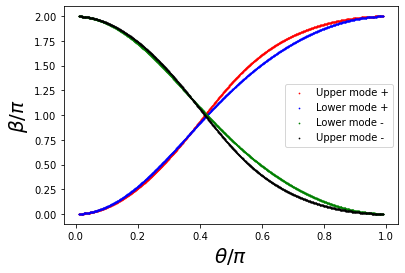

In [318]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, berry1/np.pi,s = 2, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 2, marker='.',  color = "blue")
plt.scatter(theta/np.pi, berry3/np.pi,s = 2, marker='.',  color = "green")
plt.scatter(theta/np.pi, berry4/np.pi,s = 2, marker='.',  color = "black")
plt.legend(['Upper mode +', 'Lower mode +', 'Lower mode -', 'Upper mode -'])